# CS146 Final Project
#### Dennis Kageni, Fall 2019

## Description
Modeling and forecasting atmospheric CO₂ from 1958 until 2058

Since 1958 atmospheric carbon dioxide measurements have been recorded at the Mauna Loa Observatory in Hawaii. [CO2
levels have been increasing steadily since the
start of the industrial revolution](https://www.acs.org/content/acs/en/climatescience/greenhousegases/industrialrevolution.html) in the 18th century. 

Older data are from ice core measurements, not
atmospheric measurements. The data from Mauna Loa provide very direct data on atmospheric CO2 , which forms an important part of global climate change modeling.

We will use the [weekly Mauna Loa data set](https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv) from the [Scripps CO2 program](https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html).

Your task is to create a statistical model that explains this data set well and to use it to forecast what measurements will look like between now and the start of 2058 — 40 years from now. Your model should reflect the uncertainty you have in your predictions, showing confidence intervals widening as we go further away from the present time. You will also use the model to predict when we are likely to reach high-risk levels of CO2 with a greater probability of serious climate change.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
import pystan

## The Data
The weekly Mauna Loa data set has 2 columns — the date and the measurement of CO2 ppm
(parts per million). For modeling purposes we represent time, t, using the number of days since measurements started in 1958, and the measured value, $x_t$, as the CO2 ppm measurement. **At the time of writing, there are 3139 values in the data set**

In [2]:
# import the data-set
data = pd.read_csv(
    "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv", 
    skiprows=44, names=["Date", "CO2_concentration"])
print(data.shape)
data.head()

(3139, 2)


,Date,CO2_concentration
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [3]:
#convert the "Date" column into datetime64 dtype
data["Date"] = pd.to_datetime(data["Date"])

In [4]:
data["Days_Passed"] = ((pd.to_datetime(data.Date) - pd.to_datetime(data.Date[0])).dt.days)
data["Years"] = ((pd.to_datetime(data.Date) - pd.to_datetime(data.Date[0])).dt.days)/365.25
data.tail()

,Date,CO2_concentration,Days_Passed,Years
3134,2019-08-31,409.32,22435,61.423682
3135,2019-09-07,408.80,22442,61.442847
3136,2019-09-14,408.61,22449,61.462012
3137,2019-09-21,408.50,22456,61.481177
3138,2019-09-28,408.28,22463,61.500342


In [5]:
# check datatypes
result = data.dtypes
result

Date                 datetime64[ns]
CO2_concentration           float64
Days_Passed                   int64
Years                       float64
dtype: object

In [6]:
#check for missing values
data.isnull().sum()

Date                 0
CO2_concentration    0
Days_Passed          0
Years                0
dtype: int64

/Users/denniskageni/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


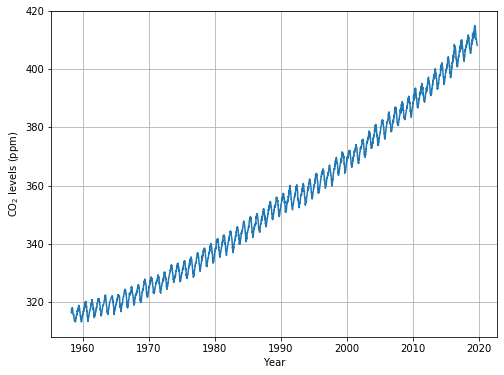

In [7]:
# plotting the data (1958 - 2019)
fig = plt.figure(figsize=(8,6))
plt.plot(data.Date, data.CO2_concentration)
plt.grid()
plt.xlabel("Year")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()

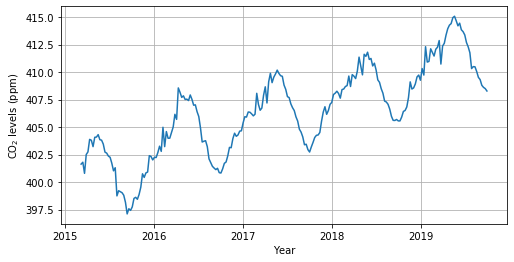

In [8]:
# zooming into the data to observe the trend, season variation and noise closely; 
# plotting from 2014-2019
fig = plt.figure(figsize=(8,4))
plt.plot(data.loc[2900:, ["Date"]], data.loc[2900:, ["CO2_concentration"]])
plt.grid()
plt.xlabel("Year")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()

## The Model
You are required to model three components — an overall trend, seasonal variations, and, noise. You will need to identify the parameters of your model, put priors over them, and calculate posterior distributions so that you can predict what atmospheric CO2 levels will look like up to the start of 2058.

### Trend

In [9]:
#stan data
stan_data = {
                'N': len(data), 
                'co2': data.CO2_concentration.values,
                'time': data.Years.values
            }

normalized_stan_data = {
                'N': len(data), 
                'co2': data.CO2_concentration.values,
                'time': data.Years.values/np.max(data.Years.values)
            }

In [10]:
linear_trend = """
data {
    int<lower=0> N;             // number of data collected
    real<lower=0> time[N];      // days passed since 1958-03-29
    real<lower=0> co2[N];       // measured CO2 concentration in ppm
}

parameters {
    real<lower=0> c0;                
    real<lower=0> c1;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0 ~ normal(310, 30);       // value inferred from the data's mean and standard deviation
    c1 ~ gamma(0.5, 0.5);       
                                
    noise ~ inv_gamma(10, 2);   
                                
    
    // Trend Model
    for (i in 1:N) {
        co2[i] ~ normal(c0 + c1*time[i], noise); 
    }
}

"""
linear_model = pystan.StanModel(model_code=linear_trend)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_89154813d1e988501886bbe0da3c6fa6 NOW.


In [11]:
exp_trend = """
data {
    int<lower=0> N;             // number of data
    real<lower=0> time[N];      // days since start of measurement
    real<lower=0> co2[N];       // measured CO2 in ppm
}

parameters {
    real<lower=0> c0;                
    real<lower=0> c1;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0 ~ normal(310, 30);       
    c1 ~ gamma(1, 1);         // expecting c1 to be relatively small 
    noise ~ inv_gamma(5, 2);      
    
    // Trend Model
    for (i in 1:N) {
        co2[i] ~ normal(c0 * exp(c1 * time[i]), noise); 
    }
}

"""
exp_model = pystan.StanModel(model_code=exp_trend)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_428bba425b3d6dec0d2282be720c0406 NOW.


In [12]:
quadratic_trend = """
data {
    int<lower=0> N;             // number of data
    real<lower=0> time[N];      // days since start of measurement
    real<lower=0> co2[N];       // measured ppm
}

parameters {
    real<lower=0> c0;                
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0 ~ normal(310, 30);
    c1 ~ normal(0, 5);
    c2 ~ normal(0, 2);
    
    noise ~ normal(10, 2);
    
    for (i in 1:N) {
        co2[i] ~ normal(c0 + c1*time[i] + c2 *(time[i]^2), noise); 
    }
}

"""
quadratic_model = pystan.StanModel(model_code=quadratic_trend)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0a7d0d175e8b7288e31d13a5d42e3086 NOW.


In [13]:
linear_results = linear_model.sampling(data=stan_data)
print(linear_results)

Inference for Stan model: anon_model_89154813d1e988501886bbe0da3c6fa6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    306.06  3.1e-3   0.15 305.77 305.96 306.06 306.17 306.35   2315    1.0
c1      1.57  9.2e-5 4.2e-3   1.57   1.57   1.57   1.58   1.58   2021    1.0
noise   4.26  1.6e-3   0.05   4.15   4.22   4.26   4.29   4.36   1147    1.0
lp__   -6134    0.03   1.21  -6138  -6135  -6134  -6134  -6133   1327    1.0

Samples were drawn using NUTS at Mon Dec 30 02:45:55 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [14]:
exp_results = exp_model.sampling(data=normalized_stan_data)
print(exp_results)

Inference for Stan model: anon_model_428bba425b3d6dec0d2282be720c0406.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    307.99  2.7e-3   0.12 307.76 307.91 307.99 308.07 308.22   1843    1.0
c1      0.27  1.5e-5 6.0e-4   0.27   0.27   0.27   0.28   0.28   1727    1.0
noise   3.47  1.5e-3   0.04   3.39   3.44   3.47    3.5   3.56    847    1.0
lp__   -5479    0.04   1.26  -5483  -5480  -5479  -5478  -5478   1071    1.0

Samples were drawn using NUTS at Mon Dec 30 02:46:09 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [15]:
quadratic_results = quadratic_model.sampling(data = stan_data)
print(quadratic_results)

Inference for Stan model: anon_model_0a7d0d175e8b7288e31d13a5d42e3086.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    314.58  3.7e-3   0.13 314.32 314.49 314.58 314.66 314.83   1205    1.0
c1      0.77  3.4e-4 9.6e-3   0.75   0.76   0.77   0.77   0.79    819    1.0
c2      0.01  5.2e-6 1.5e-4   0.01   0.01   0.01   0.01   0.01    841    1.0
noise   2.25  8.0e-4   0.03    2.2   2.23   2.25   2.27   2.31   1294    1.0
lp__   -4120    0.04   1.48  -4124  -4121  -4120  -4119  -4118   1270    1.0

Samples were drawn using NUTS at Mon Dec 30 02:46:34 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


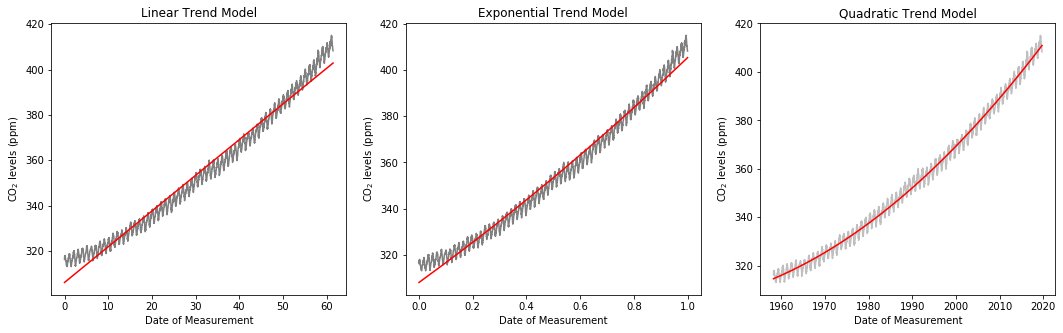

In [16]:
# plots showing the trend curves for the 
# linear, exponential & quadratic models

linear_samples = linear_results.extract()
exp_samples = exp_results.extract()
quadratic_samples = quadratic_results.extract()

linear_approx = linear_samples['c0'].mean() + linear_samples['c1'].mean()*data.Years.values

exp_approx = (exp_samples['c0'].mean()*np.exp(exp_samples['c1'].mean()*data.Years.values/np.max(data.Years.values)))

quadratic_approx = (quadratic_samples['c0'].mean() +
                    quadratic_samples['c1'].mean()*data.Years.values +
                    quadratic_samples['c2'].mean()*data.Years.values**2)


fig = plt.figure(figsize=(18,5))
plt.subplot(1, 3, 1)
plt.plot(data.Years.values, data.CO2_concentration, color='gray')
plt.plot(data.Years.values, linear_approx, color='red')
plt.title("Linear Trend Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 2)
plt.plot(data.Years.values / np.max(data.Years.values), data.CO2_concentration, color='gray')
plt.plot(data.Years.values / np.max(data.Years.values), exp_approx, color='red')
plt.title("Exponential Trend Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 3)
plt.plot(data.Date, data.CO2_concentration, alpha=0.5, color='gray')
plt.plot(data.Date, quadratic_approx, color="red")
plt.title("Quadratic Trend Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()


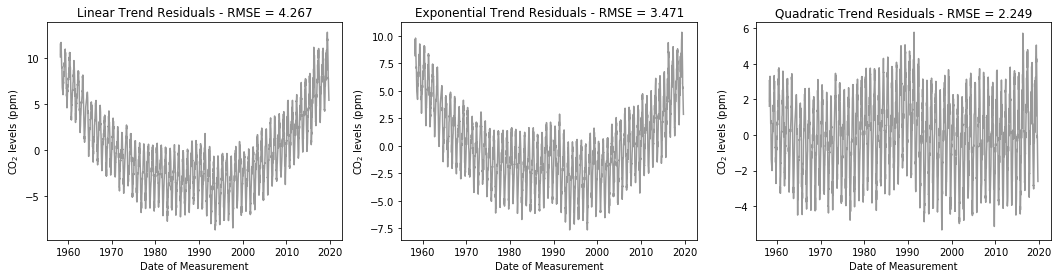

In [17]:
# calculating the RMSE for the linear, exponential and quadratic trend models
# we'll use the one with the least RMSE 
linear_residuals = data.CO2_concentration - linear_approx
quadratic_residuals = data.CO2_concentration - quadratic_approx
exponential_residuals = data.CO2_concentration - exp_approx

linear_RMSE = np.sqrt(np.mean(linear_residuals**2))
quadratic_RMSE = np.sqrt(np.mean(quadratic_residuals**2))
exponential_RMSE = np.sqrt(np.mean(exponential_residuals**2))

fig = plt.figure(figsize=(18,4))
plt.subplot(1, 3, 1)
plt.plot(data.Date, linear_residuals, alpha = 0.8, color="grey")
plt.title("Linear Trend Residuals - RMSE = {:.3f}".format(linear_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 2)
plt.plot(data.Date, exponential_residuals, alpha = 0.8, color="grey")
plt.title("Exponential Trend Residuals - RMSE = {:.3f}".format(exponential_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 3, 3)
plt.plot(data.Date, quadratic_residuals, alpha = 0.8, color="grey")
plt.title("Quadratic Trend Residuals - RMSE = {:.3f}".format(quadratic_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()

## Seasonality

Recall that figure 1 has repeated small dips in the curve. Next, we're going to try to better understand what's going on. But first, we need to remove the influuence of the upward trend by taking the first difference of values. This will give us the month-to-month changes in carbon dioxide

In [18]:
data['Differenced_Seqence'] = data.CO2_concentration - quadratic_approx

In [19]:
data.head()

,Date,CO2_concentration,Days_Passed,Years,Differenced_Seqence
0,1958-03-29,316.19,0,0.000000,1.614051
1,1958-04-05,317.31,7,0.019165,2.719345
2,1958-04-12,317.69,14,0.038330,3.084629
3,1958-04-19,317.58,21,0.057495,2.959903
4,1958-04-26,316.48,28,0.076660,1.845168


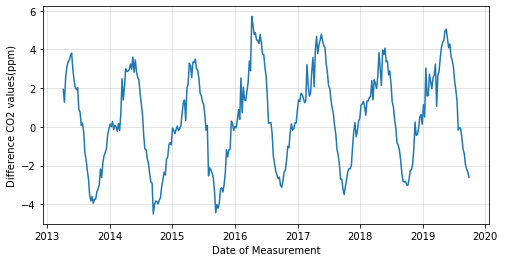

In [20]:
fig = plt.figure(figsize=(8,4))
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["Differenced_Seqence"]])
plt.grid(alpha=0.4)
plt.xlabel("Date of Measurement")
plt.ylabel("Difference CO2 values(ppm)")
plt.show()

In [21]:
stan_seasonality_data = {
    "N" : len(data),
    "co2" : data.Differenced_Seqence.values,
    "time" : data.Years.values,
    "period" : 2*np.pi
}

stan_seasonality_data_ = {
    "N" : len(data),
    "time" : data['Days_Passed'],
    'co2': data['CO2_concentration']
}


In [22]:
sine_approx = """
data {
    int<lower=0> N;             // number of data
    real<lower=0> time[N];     // days since start of measurement
    real co2[N];                // measured CO2 in ppm
    real<lower=0> period;
}

parameters {
    real<lower=0> c0;                
    real<lower=0, upper=1> c1_helper;
    real<lower=0, upper=1> c1_helper2;
    real<lower=0> noise;
}

transformed parameters {
    real c1 = atan2(c1_helper, c1_helper2);
}

model {
 
    // Priors
    c0 ~ gamma(4, 2);
    noise ~ inv_gamma(3, 2);

    for (i in 1:N) {
        co2[i] ~ normal(c0 * sin(period*time[N] + c1), noise); 
    }
}

"""
sine_model = pystan.StanModel(model_code=sine_approx)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_02062766c5c44b91ff89b0527834e333 NOW.


In [23]:
cosine_approx = """
data {
    int<lower=0> N;             // number of data
    real<lower=0> time[N];     // days since start of measurement
    real co2[N];                // measured CO2 in ppm
    real<lower=0> period;
}

parameters {
    real<lower=0> c0;                
    real<lower=0, upper=1> c1_helper;
    real<lower=0, upper=1> c1_helper2;
    real<lower=0> noise;
}

transformed parameters {
    real<lower=0> c1 = atan2(c1_helper, c1_helper2);
}

model {
 
    // Priors
    c1_helper ~ beta(1,1);
    c1_helper2 ~ beta(1,1);
    c0 ~ gamma(4, 2);
    noise ~ inv_gamma(3, 2);

    for (i in 1:N) {
        co2[i] ~ normal(c0 * cos(period*time[N] + c1), noise); 
    }
}

"""
cosine_model = pystan.StanModel(model_code=cosine_approx)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6eeb0f2bad0c9cff4a7c186332318db2 NOW.


In [24]:
aperiodic_sine_wave_approx = """
data {
    int<lower=0> N;             // number of data
    real<lower=0> time[N];     // days since start of measurement
    real co2[N];                // measured CO2 in ppm
}

parameters {                    //labelled by how they affect the function
    real<lower=0> c0; 
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> c3;
    real<lower=0> c4;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0 ~ gamma(1, 1);
    c1 ~ gamma(1, 1);
    c2 ~ gamma(1, 1);
    c3 ~ gamma(6, 2);
    c4 ~ gamma(1, 1);

    noise ~ inv_gamma(3, 2);

    for (i in 1:N) {
        co2[i] ~ normal( (-(1 + exp(-c0 * c3 * time[N] + c4) *
                         atan( 
                         sin(c3 * time[N] + c4) /
                         (1 + exp(-c1) - cos(c3 * time[N] + c4)) ))) + c2, noise); 
    }
}

"""
aperiodic_sine_wave_model = pystan.StanModel(model_code=aperiodic_sine_wave_approx)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_032eea9a521c4a3fe1029d38e66bac4a NOW.


In [25]:
double_sine_approx = """
data {
    int<lower=0> N;             // number of data
    real<lower=0> time[N];       // days since start of measurement
    real co2[N];      // measured ppm
    real<lower=0> period;
}

parameters {
    real<lower=0> c0;                
    real<upper=0> c1;
    unit_vector[2] phase_helper1;
    real<lower=0> noise;
}

transformed parameters {
    real phase1 = atan2(phase_helper1[1],phase_helper1[2]);
}

model {
 
    // Priors
    c0 ~ normal(0, 4);
    c1 ~ normal(0, 4);
    noise ~ inv_gamma(3, 2);

    for (i in 1:N) {
        co2[i] ~ normal(c0*sin(period*time[i] + phase1) + c1*sin(period*2*time[i] + phase1), noise); 
    }
}

"""
double_sine_model = pystan.StanModel(model_code=double_sine_approx)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2eb2a051271c5521f1804c5b61e61206 NOW.


### Results and Samples

#### Sine Model

In [26]:
sine_results = sine_model.sampling(data=stan_seasonality_data)
print(sine_results)

Inference for Stan model: anon_model_02062766c5c44b91ff89b0527834e333.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0           1.46    0.02   0.86   0.28   0.84   1.31   1.92   3.53   2637    1.0
c1_helper    0.02  1.1e-3   0.04 4.8e-4 4.9e-3   0.01   0.03    0.1   1420    1.0
c1_helper2   0.66  4.7e-3   0.24   0.15   0.48   0.71   0.87   0.99   2674    1.0
noise        2.25  5.6e-4   0.03   2.19   2.23   2.25   2.27   2.31   2527    1.0
c1           0.03  1.5e-3   0.06 9.9e-4 8.9e-3   0.02   0.04   0.14   1533    1.0
lp__        -4126    0.04   1.61  -4130  -4126  -4125  -4125  -4124   1306    1.0

Samples were drawn using NUTS at Mon Dec 30 02:48:41 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


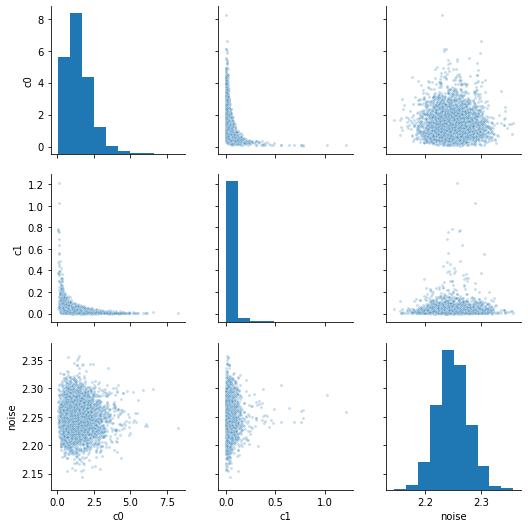

In [27]:
parameters = ['c0', 'c1', 'noise']
sine_samples = sine_results.extract()

df = pd.DataFrame(
    data=np.transpose([sine_samples[p] for p in parameters]),
    columns=parameters)
sns.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [28]:
cosine_results = cosine_model.sampling(data=stan_seasonality_data)
print(cosine_results)

Inference for Stan model: anon_model_6eeb0f2bad0c9cff4a7c186332318db2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0            1.5    0.02   0.87   0.29   0.86   1.34   1.93   3.59   2469    1.0
c1_helper    0.67  4.8e-3   0.24   0.17   0.51   0.72   0.87   0.99   2397    1.0
c1_helper2   0.02  9.6e-4   0.04 4.9e-4 5.0e-3   0.01   0.03    0.1   1460    1.0
noise        2.25  5.9e-4   0.03   2.19   2.23   2.25   2.27   2.31   2420    1.0
c1           1.54  1.2e-3   0.05   1.43   1.53   1.55   1.56   1.57   1463    1.0
lp__        -4126    0.04    1.6  -4130  -4126  -4125  -4124  -4124   1500    1.0

Samples were drawn using NUTS at Mon Dec 30 02:52:10 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


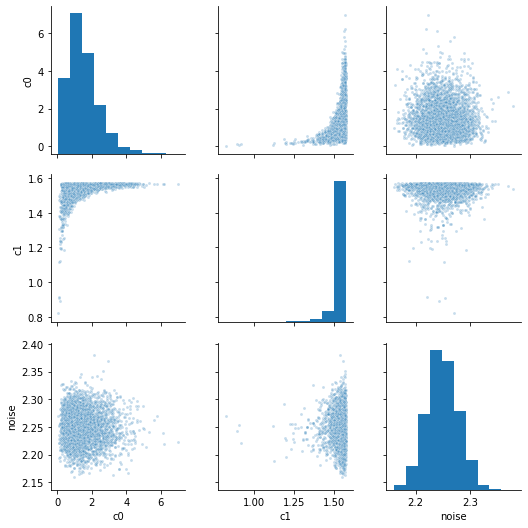

In [29]:
parameters = ['c0', 'c1', 'noise']
cos_samples = cosine_results.extract()

df = pd.DataFrame(
    data=np.transpose([cos_samples[p] for p in parameters]),
    columns=parameters)
sns.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [30]:
double_sine_results = double_sine_model.sampling(data=stan_seasonality_data)
print(double_sine_results)

Inference for Stan model: anon_model_2eb2a051271c5521f1804c5b61e61206.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0                 2.86  6.7e-4   0.02   2.82   2.85   2.86   2.87    2.9   1033   1.01
c1                -0.51  6.1e-3   0.03  -0.56  -0.53  -0.51  -0.49  -0.47     17   1.09
phase_helper1[1]   0.93  6.3e-5 2.9e-3   0.92   0.93   0.93   0.93   0.94   2037   1.01
phase_helper1[2]   0.37  1.6e-4 7.2e-3   0.35   0.36   0.37   0.37   0.38   2017   1.01
noise              0.92  1.0e-3   0.01    0.9   0.91   0.91   0.92   0.94    123   1.03
phase1             1.19  1.7e-4 7.8e-3   1.18   1.19   1.19    1.2   1.21   2020   1.01
lp__              -1301    0.19   1.68  -1305  -1302  -1301  -1300  -1299     77    1.1

Samples were drawn using NUTS at Mon Dec 30 02:53:42 2019.
For each parameter, n_eff is a crude measure of

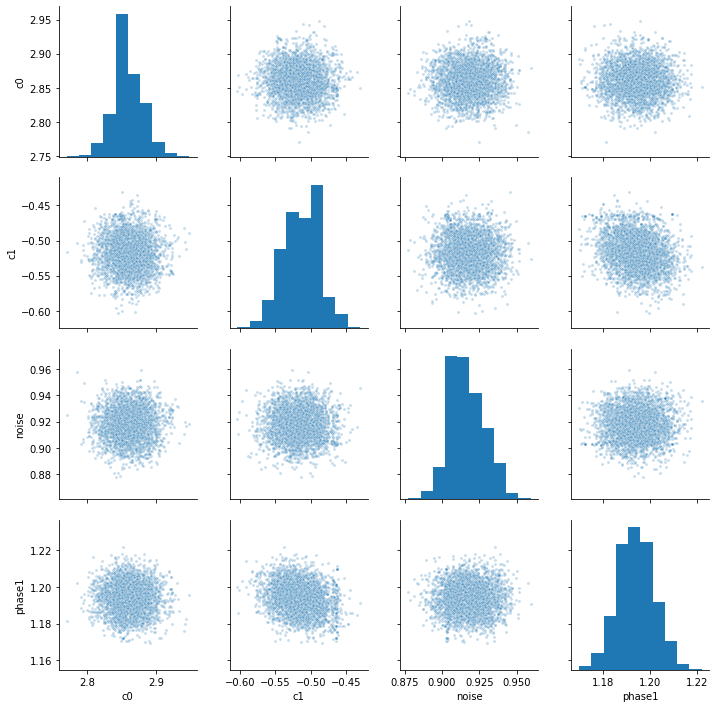

In [31]:
parameters = ['c0', 'c1', 'noise', 'phase1']
double_sine_samples = double_sine_results.extract()

df = pd.DataFrame(
    data=np.transpose([double_sine_samples[p] for p in parameters]),
    columns=parameters)
sns.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [32]:
aperiodic_sine_wave_results = aperiodic_sine_wave_model.sampling(data=stan_seasonality_data)
print(aperiodic_sine_wave_results)

Inference for Stan model: anon_model_032eea9a521c4a3fe1029d38e66bac4a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0      1.02    0.01    1.0   0.05   0.31   0.71   1.41   3.68   4834    1.0
c1       1.0    0.01    1.0   0.03   0.29   0.69   1.38   3.71   5353    1.0
c2       1.0  6.0e-4   0.04   0.92   0.97    1.0   1.02   1.08   4696    1.0
c3      3.03    0.02   1.25   1.07   2.12   2.85   3.77   5.92   4881    1.0
c4      1.01    0.01    1.0   0.03    0.3   0.72   1.41    3.7   5657    1.0
noise   2.25  4.2e-4   0.03   2.19   2.23   2.25   2.27   2.31   4558    1.0
lp__   -4122    0.05   1.81  -4127  -4123  -4122  -4121  -4120   1501    1.0

Samples were drawn using NUTS at Mon Dec 30 02:54:40 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

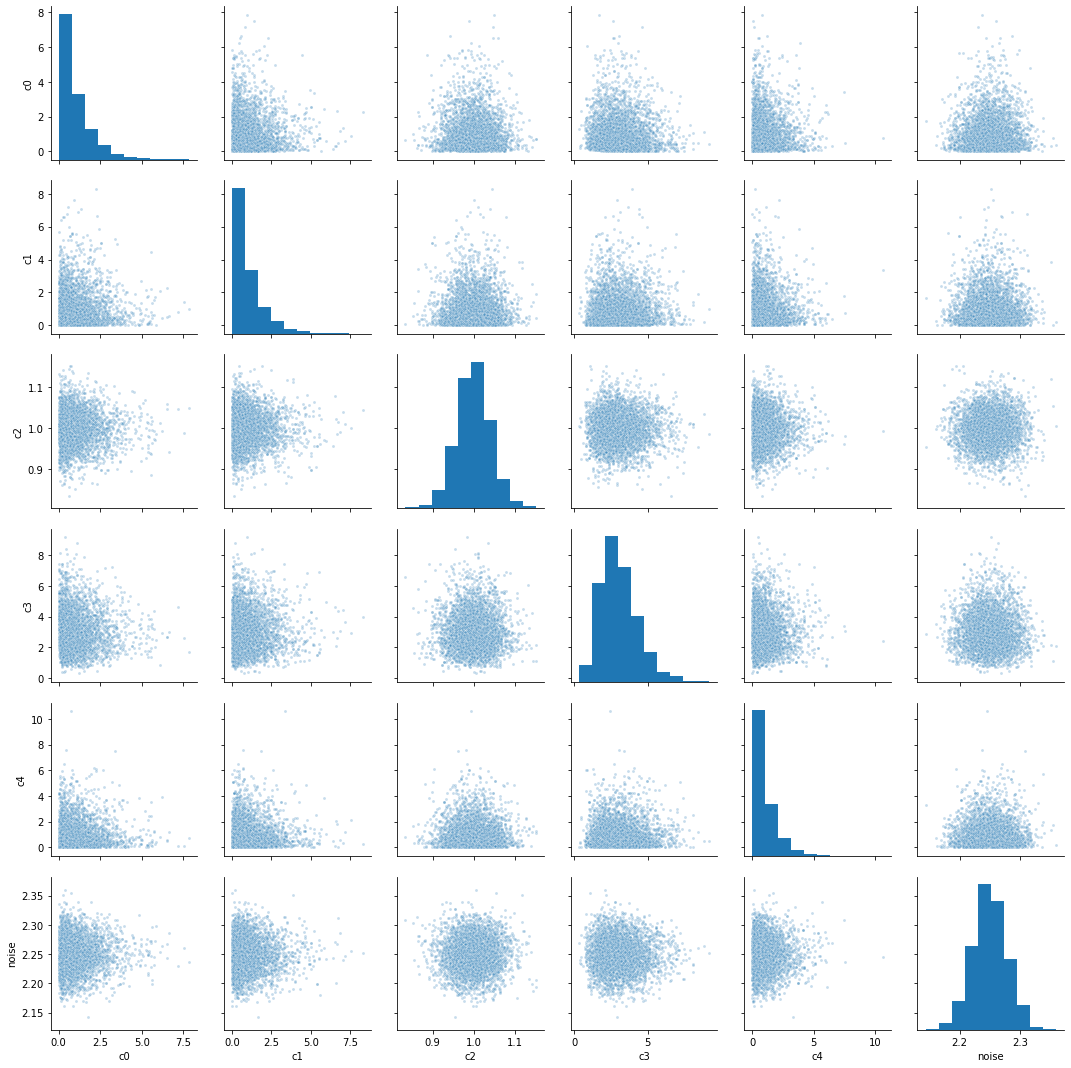

In [33]:
parameters = ['c0', 'c1', 'c2', 'c3', 'c4', 'noise']
aperiodic_sine_wave_samples = aperiodic_sine_wave_results.extract()

df = pd.DataFrame(
    data=np.transpose([aperiodic_sine_wave_samples[p] for p in parameters]),
    columns=parameters)
sns.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [34]:
def aperiodic_sine(x, c0, c1, c2, c3, c4):
    '''
    '''
    return ((-(1+np.exp(-c0* c3*x +c4)) *
            np.arctan(
            np.sin(c3*x +c4) / (1+np.exp(-c1)-np.cos(c3*x+4)) + c2 )))

#### Visualizing the seasonality models' fit

In [35]:
sine_approx = sine_samples['c0'].mean() * np.sin(2*np.pi*data.Years.values + sine_samples['c1'].mean())

cos_approx = cos_samples['c0'].mean() * np.cos(2*np.pi*data.Years.values + cos_samples['c1'].mean())

double_sine_approx = double_sine_samples['c0'].mean()*np.sin(
                                 2*np.pi*data.Years.values + double_sine_samples['phase1'].mean()) + \
                              double_sine_samples['c1'].mean()*np.sin(
                                 4*np.pi*data.Years.values + double_sine_samples['phase1'].mean())

aperiodic_sine_wave_approx = aperiodic_sine(data.Years.values, 
                                            aperiodic_sine_wave_samples['c0'].mean(),
                                            aperiodic_sine_wave_samples['c1'].mean(),
                                            aperiodic_sine_wave_samples['c2'].mean(),
                                            aperiodic_sine_wave_samples['c3'].mean(),
                                            aperiodic_sine_wave_samples['c4'].mean())



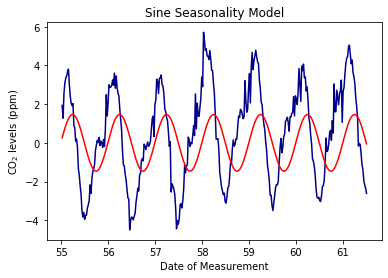

In [36]:
plt.plot(data.Years.values[2800:], data.Differenced_Seqence.values[2800:], color='darkblue')
plt.plot(data.Years.values[2800:], sine_approx[2800:], color='red')
plt.title("Sine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()

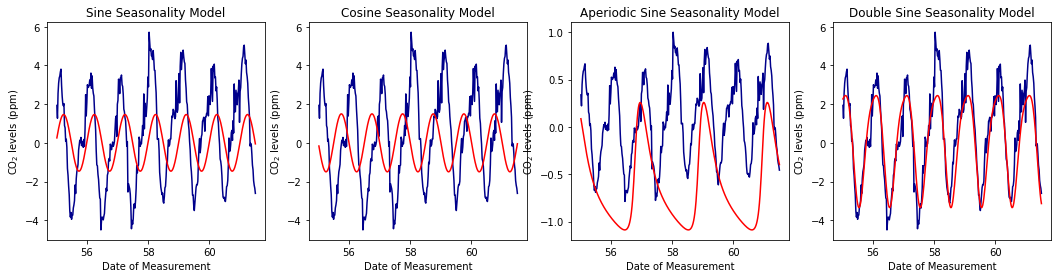

In [37]:
fig = plt.figure(figsize=(18,4))
plt.subplot(1, 4, 1)
plt.plot(data.Years.values[2800:], data.Differenced_Seqence.values[2800:], color='darkblue')
plt.plot(data.Years.values[2800:], sine_approx[2800:], color='red')
plt.title("Sine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 4, 2)
plt.plot(data.Years.values[2800:], data.Differenced_Seqence.values[2800:], color='darkblue')
plt.plot(data.Years.values[2800:], cos_approx[2800:], color='red')
plt.title("Cosine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 4, 3)
normalized_data = [x/np.max(data.Differenced_Seqence.values[2000:])
               for x in data.Differenced_Seqence.values[2800:]]
plt.plot(data.Years.values[2800:], normalized_data, color='darkblue')
plt.plot(data.Years.values[2800:], aperiodic_sine_wave_approx[2800:], color='red')
plt.title("Aperiodic Sine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 4, 4)
plt.plot(data.Years.values[2800:], data.Differenced_Seqence.values[2800:], color='darkblue')
plt.plot(data.Years.values[2800:], double_sine_approx[2800:], color='red')
plt.title("Double Sine Seasonality Model")
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.show()

In [38]:
sine_residuals = data.Differenced_Seqence - sine_approx
cosine_residuals = data.Differenced_Seqence - cos_approx
double_sine_residuals = data.Differenced_Seqence - double_sine_approx
aperiodic_sine_residuals = data.Differenced_Seqence - aperiodic_sine_wave_approx


sine_RMSE = np.sqrt(np.mean(sine_residuals**2))
cosine_RMSE = np.sqrt(np.mean(cosine_residuals**2))
double_sine_RMSE = np.sqrt(np.mean(double_sine_residuals**2))
aperiodic_sine_RMSE = np.sqrt(np.mean(aperiodic_sine_wave_approx**2))


/Users/denniskageni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


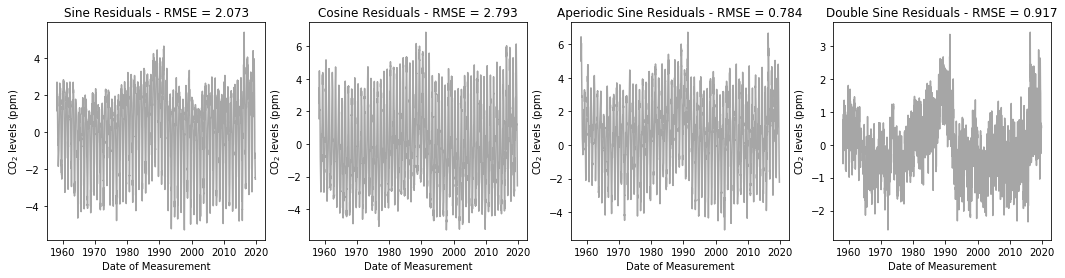

In [39]:
fig = plt.figure(figsize=(18,4))
plt.subplot(1, 4, 1)
plt.plot(data.Date, sine_residuals, alpha = 0.7, color="grey")
plt.title("Sine Residuals - RMSE = {:.3f}".format(sine_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 4, 2)
plt.plot(data.Date, cosine_residuals, alpha = 0.7, color="grey")
plt.title("Cosine Residuals - RMSE = {:.3f}".format(cosine_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 4, 4)
plt.plot(data.Date, double_sine_residuals, alpha = 0.7, color="grey")
plt.title("Double Sine Residuals - RMSE = {:.3f}".format(double_sine_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 4, 3)
plt.plot(data.Date, aperiodic_sine_residuals, alpha = 0.7, color="grey")
plt.title("Aperiodic Sine Residuals - RMSE = {:.3f}".format(aperiodic_sine_RMSE))
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.subplot(1, 4, 4)


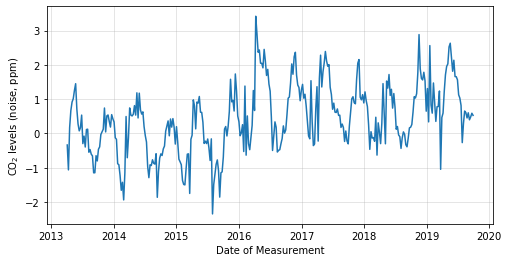

In [40]:
data["noise"] = double_sine_residuals

fig = plt.figure(figsize=(8,4))
plt.plot(data.loc[2800:, ["Date"]], data.loc[2800:, ["noise"]])
plt.grid(alpha=0.4)
plt.xlabel("Date of Measurement")
plt.ylabel(r'CO$_2$ levels (noise, ppm)')
plt.show()

In [41]:
# Retrieving the posterior samples of the coefficients
trend_coef_samples = np.array(list(map(list, zip(*quadratic_samples.values()))))[:2000, :3]
season_coefs_samples = list(map(list, zip(*double_sine_samples.values())))

# Ignoring the posterior samples of the phase helpers
season_coefs_samples = np.array([sample[:2] + sample[3:5] for sample in season_coefs_samples])

In [42]:
# likelihood / posterior predictive function
def likelihood(time, trend_coefs, season_coefs):
    c0, c1, c2 = trend_coefs
    c3, c5, noise, phase = season_coefs
    return(np.array(sts.norm.rvs(c0 + c1*time + c2*time**2 + \
                                 c3*np.sin(2*np.pi*time + phase) + \
                                 c5*np.sin(4*np.pi*time + phase), noise))) 

## Inference

In [43]:
# Dates for which we want to generate predictions
prediction_dates = pd.date_range("2019-01-01", "2058-03-29", freq='W-FRI')
prediction_times = (prediction_dates - pd.to_datetime(data.Date[0])).days / 365.25

# Generate predictions
y_pred = np.array([likelihood(prediction_times, trend_coefs, season_coefs) \
                   for trend_coefs, season_coefs in zip(trend_coef_samples, season_coefs_samples)])

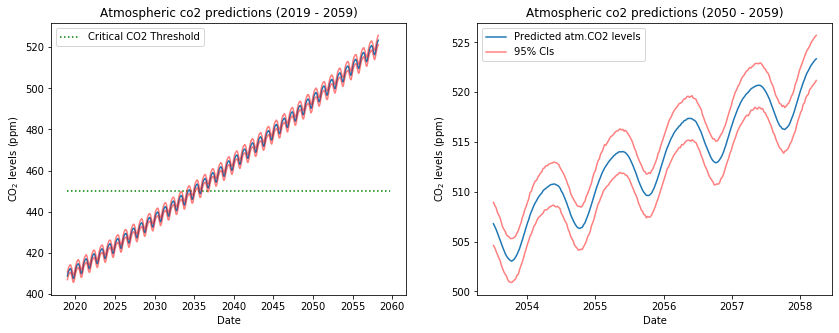

In [44]:
# Mean and CI of the predictions
mean_pred = y_pred.mean(axis=0)
CI_lower = np.percentile(y_pred, axis=0, q=2.5)
CI_upper = np.percentile(y_pred, axis=0, q=97.5)
start1 = pd.Timestamp('2019-01-01')
end1 = pd.Timestamp(data.Date.iloc[-1])
end2 = pd.Timestamp('2059-09-28')   #end of data + 40 years

fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Atmospheric co2 predictions (2019 - 2059)")
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.plot(prediction_dates, mean_pred)
plt.plot(prediction_dates, CI_lower, color="red", alpha=0.5)
plt.plot(prediction_dates, CI_upper, color="red", alpha=0.5)
plt.hlines(450, start1, end2,
           color='green', linestyle=':', label="Critical CO2 Threshold")
plt.legend(prop={'size': 10})

plt.subplot(1,2,2)
plt.title("Atmospheric co2 predictions (2050 - 2059)")
plt.xlabel("Date")
plt.ylabel(r'CO$_2$ levels (ppm)')
plt.plot(prediction_dates[1800:], mean_pred[1800:],label="Predicted atm.CO2 levels")
plt.plot(prediction_dates[1800:], CI_lower[1800:], color="red", alpha=0.5)
plt.plot(prediction_dates[1800:], CI_upper[1800:], color="red", alpha=0.5, label="95% CIs")
plt.legend(prop={'size': 10})
plt.show()


In [45]:
data_pred = pd.DataFrame({"Date":prediction_dates, 
                          "2.5%":CI_lower, 
                          "Mean":mean_pred, 
                          "97.5":CI_upper})

In [46]:
print("The predicted atmospheric carbon dioxide level in {:{dfmt}} is of {:.3f} ppm.".format(
    data_pred.iloc[-1,0],data_pred.iloc[-1,2], dfmt='%Y-%m-%d'))

print('The 95% confidence interval is [{:.3f}, {:.3f}].'.format(
    data_pred.iloc[-1,1],data_pred.iloc[-1,3]))

The predicted atmospheric carbon dioxide level in 2058-03-29 is of 523.345 ppm.
The 95% confidence interval is [521.174, 525.703].


In [47]:
print("The threshold of 450 ppm will be surpassed with high confidence in {:{dfmt}}.".format(
    prediction_dates[np.min(np.argwhere(CI_lower > 450))], dfmt='%Y-%m-%d'))

The threshold of 450 ppm will be surpassed with high confidence in 2035-02-23.


## Posterior Predictive Checks

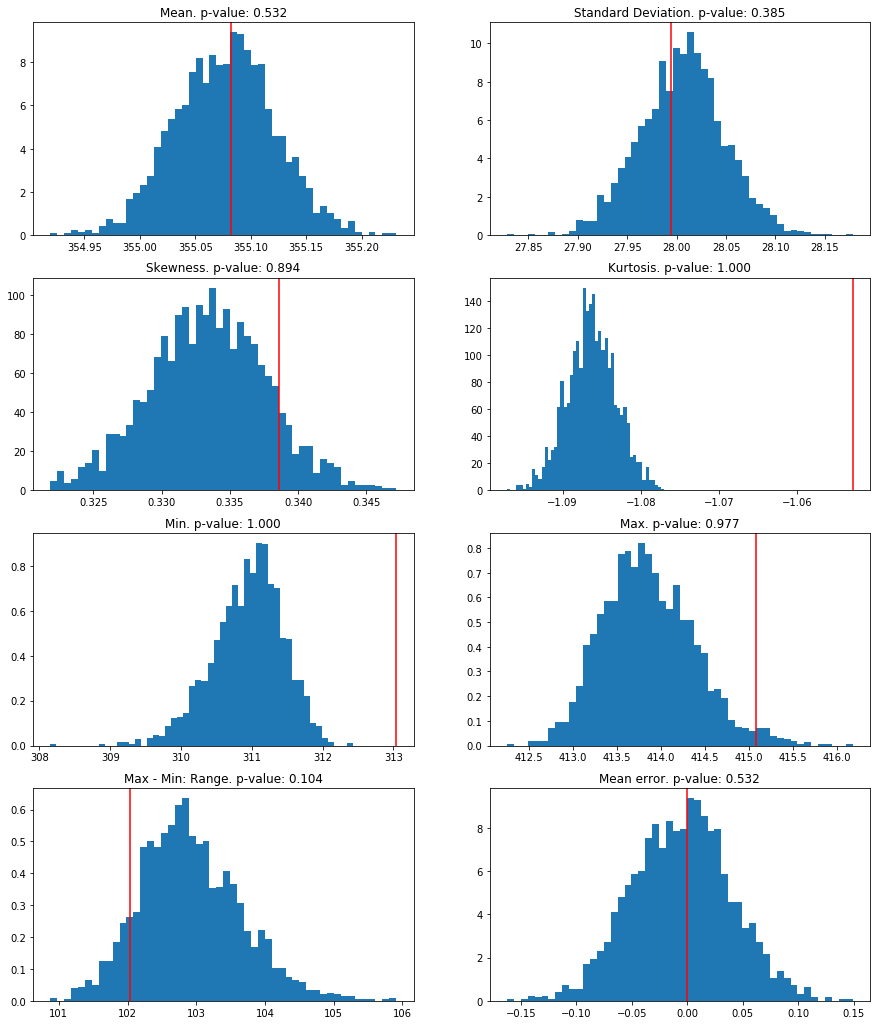

In [48]:
# Generating y_reps
y_reps = np.array([likelihood(data.Years.values, trend_coefs, season_coefs) \
                   for trend_coefs, season_coefs in zip(trend_coef_samples, season_coefs_samples)])

# Auxiliary plot function
def make_histogram(name, generated, expected_value, subplot_tuple):
    plt.subplot(*subplot_tuple)
    plt.hist(generated, bins=50, density=True)
    plt.title(name)
    # Draw red vertical line at the expected value of the test statistic.
    if expected_value is not None:
        plt.axvline(expected_value, color='red')

fig = plt.figure(figsize=(15,18))

# The test statistic for the generated data.
generated = np.mean(y_reps, axis=1)
# The measurement error is a normal distribution with 0 mean.
expected_value = np.mean(data.CO2_concentration.values)
# The name of the test statistic.
name = 'Mean. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 1))


generated = np.std(y_reps, axis=1)
expected_value = np.std(data.CO2_concentration.values)
name = 'Standard Deviation. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 2))
           

generated = sts.skew(y_reps, axis=1)
expected_value = sts.skew(data.CO2_concentration.values)
name = 'Skewness. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 3))


generated = sts.kurtosis(y_reps, axis=1)
expected_value = sts.kurtosis(data.CO2_concentration.values)
name = 'Kurtosis. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 4))


generated = np.min(y_reps, axis=1)
expected_value = np.min(data.CO2_concentration.values)
name = 'Min. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 5))


generated = np.max(y_reps, axis=1)
expected_value = np.max(data.CO2_concentration.values)
name = 'Max. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 6))


generated = np.ptp(y_reps, axis=1)
expected_value = np.ptp(data.CO2_concentration.values)
name = 'Max - Min: Range. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 7))

generated = np.mean(y_reps - data.CO2_concentration.values, axis=1)
expected_value = 0
name = 'Mean error. p-value: {:.3f}'.format(np.mean(generated < expected_value))
make_histogram(name, generated, expected_value, (4, 2, 8))

plt.show()
